<a href="https://colab.research.google.com/github/cmiglio/signal_processing_with_python/blob/master/signal_processing_with_python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Signal analysis with python

*Carolina Migliorelli*


The purpose of this workshop is to show an example on how to work with Python with signals. 
We will give some general ideas on how to **read, process and visualize data**

We will use some common python toolboxes: 
* [numpy](https://numpy.org/): It contains the main functions to work with matrices (very similar to Matlab)
* [pandas](https://pandas.pydata.org/): A way of organizing the data
* [seaborn](https://seaborn.pydata.org/): A visualization library with nice plots (that use in its backgroud [matplotlib](https://matplotlib.org/).
* [scipy](https://www.scipy.org/): We will use scipy to load mat files and also to do some signal processing (find peaks)
* [mne](https://mne.tools/stable/index.html): A package for analyzing human neurophysiological data

For this workshop, we will load data from one epileptic patient and we will extract some events of interest. We will plot the time-frequency representation of these events using the stockwell transform and we will save into a dataframe structure (a table) some meaningful features.

## 0. Installing packages
If you don't have installed the toolboxes, then you should install them. 

In [ ]:
!pip install numpy pandas seaborn scipy mne
!git clone https://github.com/cmiglio/signal_processing_with_python.git

     |████████████████████████████████| 6.4MB 3.4MB/s 
Cloning into 'signal_processing_with_python'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 12 (delta 0), reused 3 (delta 0), pack-reused 0
Unpacking objects: 100% (12/12), done.


## 1. Importing packages 
We will start importing the packages. When we use *import* we import the whole package, with the name that we put after *as*. If we don't want to import the whole package but only some functions, we can use *from*. 

In [91]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.io import loadmat
from scipy import signal
import mne
from mne.time_frequency import (tfr_array_stockwell) 
from matplotlib import pyplot as plt

## 2. Loading the data
### 2.1. Loading the data using loadmat (from scipy)
We will load the data that, in this case, is stored in a *.mat* file. We can import data with other formats using MNE ([see here](https://mne.tools/stable/auto_tutorials/io/plot_20_reading_eeg_data.html#sphx-glr-auto-tutorials-io-plot-20-reading-eeg-data-py)). But however, .TRC (micromed) files are not currently included in MNE distribution, so what I did is reading the data with matlab and then save it into a .mat file. If you are interested in knowing how to create the .mat file, I cand send you my routines. 

In [102]:
# Files were saved into a structure, you should know the names of each field
# in the structure. If not, you can check de names usign structure.keys().
# The squeeze_me parameter must be set to True.
structure = loadmat('signal_processing_with_python/signals.mat',squeeze_me=True)
data = structure['data']
sfreq = structure['sfreq']
ch_names = structure['ch_names']
ch_types = structure['ch_types']
differential = structure['differential']
average = structure['average']
needle_names = structure['needle_names']
needle = structure['needle1']
pos = structure['pos']

### 2.2. Creating an mne raw array
To work with MNE (and use filters for example), we have to create a data structure that MNE understands.  

In [103]:
# We have to change the numpy arrays to lists
info = mne.create_info(ch_names=ch_names.tolist(), sfreq=sfreq, ch_types=ch_types.tolist())
raw = mne.io.RawArray(data, info)

Creating RawArray with float64 data, n_channels=20, n_times=61441
    Range : 0 ... 61440 =      0.000 ...    60.000 secs
Ready.


## 3. Processing data
### 3.1. Filtering with MNE
We will filter the data above 80 Hz and we will notch the data to remove the line noise (50Hz and the harmonics)

In [104]:
raw.notch_filter([50, 100, 150, 200, 250], fir_design='firwin',verbose=False)
raw80 = raw.copy() # We create a copy of our data
raw80.filter(80,None,fir_design='firwin',verbose=False)

<RawArray  |  None, n_channels x n_times : 20 x 61441 (60.0 sec), ~9.4 MB, data loaded>

### 3.2. Obtaining the envelope of the signal and computing the threshold
We want to obtain the envelope of the signal using hilbert and to obtain the events that are higher than a threshold. We will set the threshold to:
``` python
mean + 5*sd.
```
(Other more sophisticated methods to obtain the threshold could be applyied)


In [105]:
raw_hilb = raw80.copy() # We create a copy of our filtered data
raw_hilb.apply_hilbert() # We apply hilbert to obtain the envelope

chan_n = 10 # We will compute this for the first channel (in python the first index is 0)

data = raw.get_data(picks=chan_n)
data80 = raw80.get_data(picks=chan_n)
data_hil = np.abs(raw_hilb.get_data(picks=chan_n))
th = np.mean(data_hil) + 5*np.std(data_hil)
change = np.diff((data_hil[0,:]>th)*1)
if change[np.where(change)[0][0]]==-1:
    change[np.where(change)[0][0]]=0
ch_pos=np.sum(change==1)
ch_neg=np.sum(change==-1)
if ch_pos>ch_neg:
            # Si hay 1 positivo mas que negativo, entonces es que hemos acabado encima del threshold--> descartamos el ultimo positivo
    p_aux_ini=np.where(change==1)[0][:-2]
    p_aux_fin=np.where(change==-1)[0]
elif ch_pos<ch_neg:
     # Si hay 1 negativo más que un positivo, entonces es que he empezado encima del threshold--> descartamos el primer negativo
    p_aux_ini=np.where(change==1)[0]
    p_aux_fin=np.where(change==-1)[0][1:]
elif ch_pos==ch_neg:
    p_aux_ini=np.where(change==1)[0]
    p_aux_fin=np.where(change==-1)[0]
eoi = np.array(list(zip(p_aux_ini,p_aux_fin)))


Lets see what we have in *eoi*

In [106]:
print(eoi)

[[ 2127  2130]
 [ 2131  2147]
 [ 7721  7744]
 [ 7754  7756]
 [49398 49402]
 [57009 57010]]


## 3. Plotting data

We will plot the data of one event using seaborn, we want to plot:
* The raw data
* The filtered data
* The time-frequency distribution computed with stockwell transform

In [107]:
# We select which event we want to plot
event_to_plot = 1 

# We define a window of 500 ms
win_size = int(0.5 * sfreq)
# We create an epoch (the structure needed by mne)
epoch = np.zeros([1,1,win_size*2])
epoch80 = np.zeros([1,1,win_size*2])
epoch_hil = np.zeros([1,1,win_size*2])

mid_event = int((eoi[event_to_plot,0]+ eoi[event_to_plot,1])/2)
epoch[0,0,:] = data[:,mid_event-win_size:mid_event+win_size]
epoch80[0,0,:] = data80[:,mid_event-win_size:mid_event+win_size]
epoch_hil[0,0,:] = data_hil[:,mid_event-win_size:mid_event+win_size]

# We compute stockwell
fmin = 1
fmax = int(sfreq/4)
freqs = np.arange(fmin,fmax)

pwr = tfr_array_stockwell(epoch, fmin=fmin, fmax=fmax, width=3, sfreq=sfreq, n_fft=int(win_size*2));

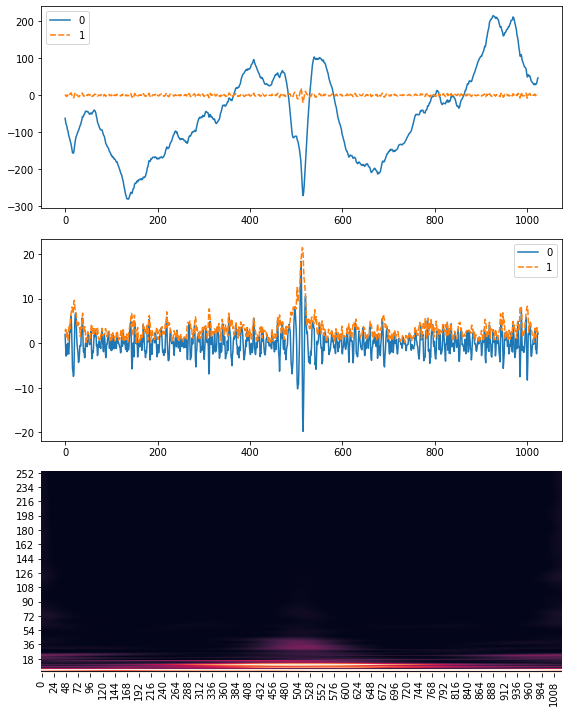

In [108]:
# We plot with seaborn
fig_size = (8, 10)
fig, ax = plt.subplots(3,figsize=fig_size)
plt.autoscale(enable=True, axis='x', tight=True)
sns.lineplot(ax=ax[0],data=[epoch[0,0,:],epoch80[0,0,:]])
sns.lineplot(ax=ax[1],data=[epoch80[0,0,:],epoch_hil[0,0,:]])
sns.heatmap(ax=ax[2],data=pwr[0][0],robust='True',cbar=False)
ax[2].set(ylim=freqs[[0, -1]])
plt.tight_layout()
# To save the image uncomment the next line
#fig.savefig('signal_plot.png')

## 4. Working with processed data and pandas
### 4.1 Creating the dataframe
Finally, we will see how to store processed data (features) in a panda's dataframe (a table). With this type of dataframes we can filter data by its characteristics and also plot statistical data. We will compute eois iterating trough all the channels and we will measure some features of that eois. We will save the features into a pandas dataframe. 

In [128]:
# We obtain a vector that have the size of the channels and other vector with 
# the same size for the threshold
channels_vector = np.arange(0,len(raw80.ch_names)) 

# Declare empty lists for all the columns of our dataframe
# (This is more efficient than appending to pandas in iterative processes)
ev_ini = list(); 
ev_fi = list();     
dur_t = list();
len_peaks = list();
mean_peak = list();
channels = list();
needles = list();
needle_name = list();
x = list();
y = list();
z = list();



for chan_n in channels_vector: # We iterate trough the channels
    data_80 = raw80.get_data(picks=chan_n) # We obtain the data for one channel
    data_hil = np.abs(raw_hilb.get_data(picks=chan_n)) # We obtain the envelope for one channel
    th = np.mean(data_hil) + 3*np.std(data_hil)
    
    # All this code is to detect events of interest that will be saved into eoi
    # Where function is similar to find
    change = np.diff((data_hil[0,:]>th)*1)
    if change[np.where(change)[0][0]]==-1:
        change[np.where(change)[0][0]]=0
    ch_pos=np.sum(change==1)
    ch_neg=np.sum(change==-1)
    if ch_pos>ch_neg:
        p_aux_ini=np.where(change==1)[0][:-2]
        p_aux_fin=np.where(change==-1)[0]
    elif ch_pos<ch_neg:
        p_aux_ini=np.where(change==1)[0]
        p_aux_fin=np.where(change==-1)[0][1:]
    elif ch_pos==ch_neg:
        p_aux_ini=np.where(change==1)[0]
        p_aux_fin=np.where(change==-1)[0]
    # We obtain the events of interest
    eoi = np.array(list(zip(p_aux_ini,p_aux_fin)))
    # Now we iterate through all the EOIs
    for event in eoi:
        # With append, we update the fields that depend on the event
        ev_ini.append(event[0])
        ev_fi.append(event[1])
        dur_t.append(event[1]-event[0])
        
        # We use the EOI +/- 10 samples
        eoi_data = data_80[0,event[0]-10:event[1]+10]
        # Find peaks
        peaks = signal.find_peaks(np.abs(eoi_data))
        
        len_peaks.append(len(peaks[0]))
        mean_peak.append(np.mean(np.diff(peaks[0])))
    # Now we update the fields that depend on the channel (we have to extend the same value)
    channels.extend([ch_names[chan_n]]*len(eoi))
    needles.extend([needle[chan_n]]*len(eoi))
    needle_name.extend([needle_names[needle[chan_n]]]*len(eoi))
    x.extend([pos[chan_n,0]]*len(eoi))
    y.extend([pos[chan_n,1]]*len(eoi))
    z.extend([pos[chan_n,2]]*len(eoi))
        
# To create the dataframe, first we will create a list with all the features

list_all = list(zip(ev_ini,ev_fi,dur_t,len_peaks,mean_peak,channels,needles,needle_name,x,y,z))
# We create the dataframe
features = pd.DataFrame(list_all, columns=['Beginning','End','Length','N peaks','Mean Peak','Channel',
                                      'Needle','Needle name','x','y','z'])

Let's see our dataframe

In [130]:
features

,Beginning,End,Length,N peaks,Mean Peak,Channel,Needle,Needle name,x,y,z
0,43,44,1,3,5.500000,TOB1,0,TOB,-0.045284,-0.011390,0.038247
1,689,690,1,6,3.400000,TOB1,0,TOB,-0.045284,-0.011390,0.038247
2,1188,1190,2,5,4.000000,TOB1,0,TOB,-0.045284,-0.011390,0.038247
3,1213,1222,9,5,5.000000,TOB1,0,TOB,-0.045284,-0.011390,0.038247
4,4134,4138,4,5,4.500000,TOB1,0,TOB,-0.045284,-0.011390,0.038247
...,...,...,...,...,...,...,...,...,...,...,...
4259,60330,60331,1,8,2.571429,OI10,1,OI,-0.064296,-0.040335,0.040313
4260,60446,60448,2,6,2.800000,OI10,1,OI,-0.064296,-0.040335,0.040313
4261,60450,60451,1,6,2.800000,OI10,1,OI,-0.064296,-0.040335,0.040313
4262,60894,60896,2,6,3.800000,OI10,1,OI,-0.064296,-0.040335,0.040313


* We can create a new column. For example, we will create a new column called Instantaneous frequency, that is:
```
1/Mean_peak * sfreq * 0.5
```

In [133]:
features['Inst freq'] = 1/features['Mean Peak'] * sfreq * 0.5

print(features.columns)

Index(['Beginning', 'End', 'Length', 'N peaks', 'Mean Peak', 'Channel',
       'Needle', 'Needle name', 'x', 'y', 'z', 'Inst freq'],
      dtype='object')


* Now, we will create a new column called "band" depending on the instant frequency. If the instant frequency is lower than 180, then the band will be equal to ripple and if it is higher, it will be equal to fast ripple

In [141]:
# First, we create a band called ripple for all the events
features['Band'] = 'Ripple' 
# Now we filter and assign to fast ripple band
features['Band'][features['Inst freq']>180] = 'Fast Ripple'

/home/cmigliorelli/anaconda3/envs/mne/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


* We can obtain descriptive statistics of all our columns

In [142]:
features.mean()

Beginning    31906.424953
End          31909.279784
Length           2.854831
N peaks          5.102017
Mean Peak        4.152662
Needle           0.380159
x               -0.052909
y               -0.028272
z                0.039347
Inst freq      128.635352
dtype: float64

* And we can filter by features

In [143]:
features[features['Length']>3]

,Beginning,End,Length,N peaks,Mean Peak,Channel,Needle,Needle name,x,y,z,Inst freq,Band
3,1213,1222,9,5,5.000000,TOB1,0,TOB,-0.045284,-0.011390,0.038247,102.400000,Ripple
4,4134,4138,4,5,4.500000,TOB1,0,TOB,-0.045284,-0.011390,0.038247,113.777778,Ripple
7,5122,5126,4,6,3.400000,TOB1,0,TOB,-0.045284,-0.011390,0.038247,150.588235,Ripple
10,7748,7753,5,6,4.000000,TOB1,0,TOB,-0.045284,-0.011390,0.038247,128.000000,Ripple
11,7754,7760,6,7,3.666667,TOB1,0,TOB,-0.045284,-0.011390,0.038247,139.636364,Ripple
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4233,53341,53345,4,5,4.250000,OI10,1,OI,-0.064296,-0.040335,0.040313,120.470588,Ripple
4234,53401,53405,4,5,4.500000,OI10,1,OI,-0.064296,-0.040335,0.040313,113.777778,Ripple
4242,56336,56340,4,5,4.000000,OI10,1,OI,-0.064296,-0.040335,0.040313,128.000000,Ripple
4246,57344,57348,4,4,5.666667,OI10,1,OI,-0.064296,-0.040335,0.040313,90.352941,Ripple


In [144]:
features[features['Channel']=='OI3']

,Beginning,End,Length,N peaks,Mean Peak,Channel,Needle,Needle name,x,y,z,Inst freq,Band
3116,257,259,2,4,5.333333,OI3,1,OI,-0.066149,-0.015926,0.039316,96.000000,Ripple
3117,678,680,2,5,4.250000,OI3,1,OI,-0.066149,-0.015926,0.039316,120.470588,Ripple
3118,702,704,2,6,3.600000,OI3,1,OI,-0.066149,-0.015926,0.039316,142.222222,Ripple
3119,1261,1263,2,5,3.500000,OI3,1,OI,-0.066149,-0.015926,0.039316,146.285714,Ripple
3120,1890,1892,2,5,4.250000,OI3,1,OI,-0.066149,-0.015926,0.039316,120.470588,Ripple
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3326,60528,60529,1,4,4.333333,OI3,1,OI,-0.066149,-0.015926,0.039316,118.153846,Ripple
3327,60547,60549,2,6,3.600000,OI3,1,OI,-0.066149,-0.015926,0.039316,142.222222,Ripple
3328,60574,60579,5,7,3.666667,OI3,1,OI,-0.066149,-0.015926,0.039316,139.636364,Ripple
3329,60933,60934,1,6,3.400000,OI3,1,OI,-0.066149,-0.015926,0.039316,150.588235,Ripple


### 4.2. Statistical data visualization.
With Pandas (dataframes) and seaborn, is easy to plot relationships between variables. We will see some examples

* Boxplot:

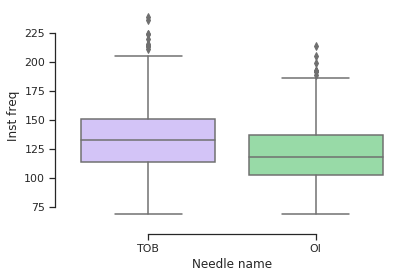

In [135]:
# We can change the color pallete, and the style, see seaborn webpage
sns.set(style="ticks", palette="pastel") 
sns.boxplot(x="Needle name", y="Inst freq", palette=["m", "g"],
            data=features)
sns.despine(offset=10, trim=True)


* Boxplot with hues

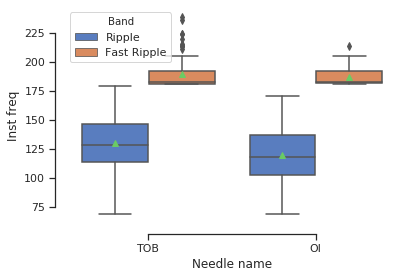

In [150]:
sns.set(style="ticks", palette="muted") 
sns.boxplot(x="Needle name", y="Inst freq", hue = "Band",
            data=features, showmeans=True)
sns.despine(offset=10, trim=True)

* Pairplot (scatterplots and distribution plots)

/home/cmigliorelli/anaconda3/envs/mne/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/home/cmigliorelli/anaconda3/envs/mne/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


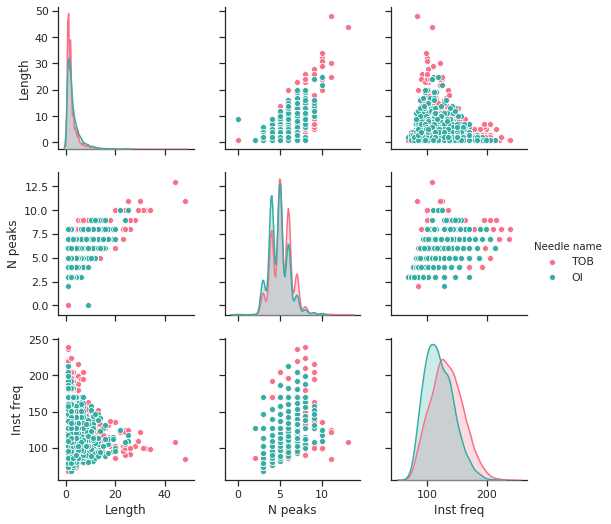

In [151]:
sns.pairplot(features,  palette="husl",
                 vars=["Length", "N peaks", "Inst freq"], hue = "Needle name")